# Machine Learning - Gözetimsiz Öğrenme: Airbnb Open Data ile Kümeleme Analizi

Bu çalışmada, Airbnb Open Data veri seti üzerinde gözetimsiz öğrenme algoritmalarından **K-Ortalama (K-Means) Kümeleme** ve **Hiyerarşik Kümeleme** yöntemlerini uygulayacağız. Ayrıca, boyut azaltma için **PCA** kullanacak, çapraz doğrulama ile modellerin başarımını inceleyecek ve en iyi modeli hiperparametre optimizasyonu ile geliştireceğiz.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from scipy.cluster.hierarchy import linkage, dendrogram
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('datasets/Airbnb_Open_Data.csv')
df.head()

,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,$193,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,$28,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,$124,3.0,0.0,NaN,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,$74,30.0,270.0,7/5/2019,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,$41,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


Veri setinin genel yapısını ve eksik değerleri inceleyelim.

In [3]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              23699 non-null  int64  
 1   NAME                            23623 non-null  object 
 2   host id                         23699 non-null  int64  
 3   host_identity_verified          23604 non-null  object 
 4   host name                       23659 non-null  object 
 5   neighbourhood group             23671 non-null  object 
 6   neighbourhood                   23682 non-null  object 
 7   lat                             23690 non-null  float64
 8   long                            23690 non-null  float64
 9   country                         23611 non-null  object 
 10  country code                    23619 non-null  object 
 11  instant_bookable                23619 non-null  object 
 12  cancellation_policy             

,0
id,0
NAME,76
host id,0
host_identity_verified,95
host name,40
neighbourhood group,28
neighbourhood,17
lat,9
long,9
country,88


In [4]:
df.describe()

,id,host id,lat,long,Construction year,minimum nights,number of reviews,reviews per month,review rate number,calculated host listings count,availability 365
count,2.369900e+04,2.369900e+04,23690.000000,23690.000000,23552.000000,23520.000000,23670.000000,19741.000000,23590.000000,23615.000000,23540.000000
mean,7.545539e+06,4.929726e+10,40.729485,-73.956340,2012.478261,7.734991,35.139079,0.966687,2.997669,3.692484,176.505098
std,3.778536e+06,2.846198e+10,0.053497,0.039904,5.776574,33.493639,57.750947,1.324036,1.418895,12.762350,135.577453
min,1.001254e+06,1.303496e+08,40.499790,-74.242850,2003.000000,-12.000000,0.000000,0.010000,1.000000,1.000000,-10.000000
25%,4.273438e+06,2.462846e+10,40.689680,-73.983060,2007.000000,2.000000,1.000000,0.110000,2.000000,1.000000,47.000000
50%,7.545539e+06,4.914931e+10,40.723175,-73.957650,2012.000000,3.000000,9.000000,0.370000,3.000000,1.000000,169.000000
75%,1.081764e+07,7.399650e+10,40.764070,-73.941150,2017.000000,5.000000,44.000000,1.340000,4.000000,2.000000,297.000000
max,1.408974e+07,9.876097e+10,40.911690,-73.712990,2022.000000,3455.000000,629.000000,16.220000,5.000000,121.000000,426.000000


Kümeleme için kullanılacak sayısal sütunları seçip eksik değerleri temizleyelim.

In [5]:
numeric_cols = ['price', 'service fee', 'minimum nights', 'number of reviews', 'reviews per month', 'review rate number', 'calculated host listings count', 'availability 365', 'lat', 'long']
df_selected = df[numeric_cols].replace({',':'', '\$':''}, regex=True)
for col in ['price', 'service fee']:
    df_selected[col] = pd.to_numeric(df_selected[col], errors='coerce')
df_selected = df_selected.dropna()

Verileri ölçeklendirelim ve PCA ile boyut azaltma uygulayalım.

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_selected)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

## K-Ortalama (K-Means) Kümeleme: Optimum Küme Sayısı (Dirsek Yöntemi)

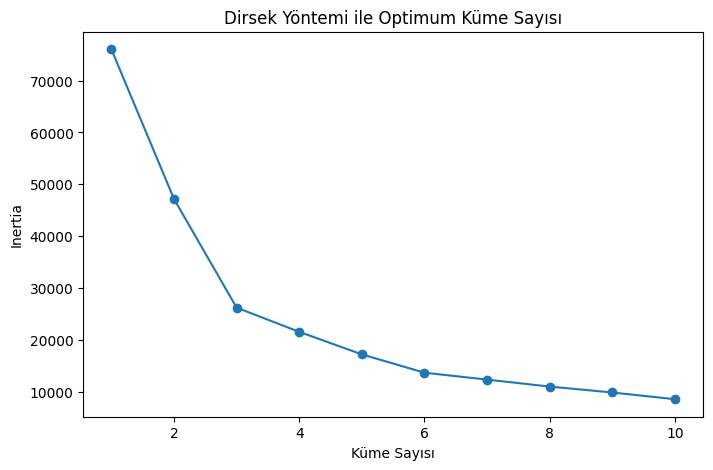

In [7]:
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertias.append(kmeans.inertia_)
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel('Küme Sayısı')
plt.ylabel('Inertia')
plt.title('Dirsek Yöntemi ile Optimum Küme Sayısı')
plt.show()

Dirsek yöntemine göre optimum küme sayısını seçip K-Means modelini eğitelim ve çapraz doğrulama ile başarımını inceleyelim.

In [8]:
optimal_k = 3  # Dirsek grafiğine göre belirlenir
y_pred_kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit_predict(X_pca)

# K-Means için silhouette skoru ile çapraz doğrulama
from sklearn.metrics import silhouette_score
score_kmeans = silhouette_score(X_pca, y_pred_kmeans)
print(f"K-Means Silhouette Skoru: {score_kmeans:.3f}")

K-Means Silhouette Skoru: 0.470


## Hiyerarşik Kümeleme (Agglomerative Clustering)

In [9]:
hierarchical = AgglomerativeClustering(n_clusters=optimal_k)
y_pred_hier = hierarchical.fit_predict(X_pca)
score_hier = silhouette_score(X_pca, y_pred_hier)
print(f"Hiyerarşik Kümeleme Silhouette Skoru: {score_hier:.3f}")

Hiyerarşik Kümeleme Silhouette Skoru: 0.422


Optimal küme sayısı belirlenerek Hiyerarşik Kümeleme modeli oluşturuluyor ve PCA ile indirgenmiş veri üzerinde uygulanıyor.  
Modelin kümeleme performansı Silhouette skoru ile ölçülüyor.

## En İyi Modelin Seçimi ve Hiperparametre Optimizasyonu

In [10]:
# En yüksek silhouette skoruna sahip modeli seçelim
if score_kmeans >= score_hier:
    best_model = KMeans(random_state=42)
    param_grid = {'n_clusters': range(2, 8), 'init': ['k-means++', 'random', 'k-means++'], 'n_init': [10, 20, 30]}
    from sklearn.model_selection import GridSearchCV
    grid = GridSearchCV(best_model, param_grid, scoring='adjusted_rand_score', cv=3)
    grid.fit(X_pca, y_pred_kmeans)
    print("K-Means için En İyi Parametreler:", grid.best_params_)
else:
    best_model = AgglomerativeClustering()
    param_grid = {'n_clusters': range(2, 8), 'linkage': ['ward', 'complete', 'average', 'single']}
    from sklearn.model_selection import GridSearchCV


K-Means için En İyi Parametreler: {'init': 'random', 'n_clusters': 3, 'n_init': 10}


## Sonuçların Görselleştirilmesi

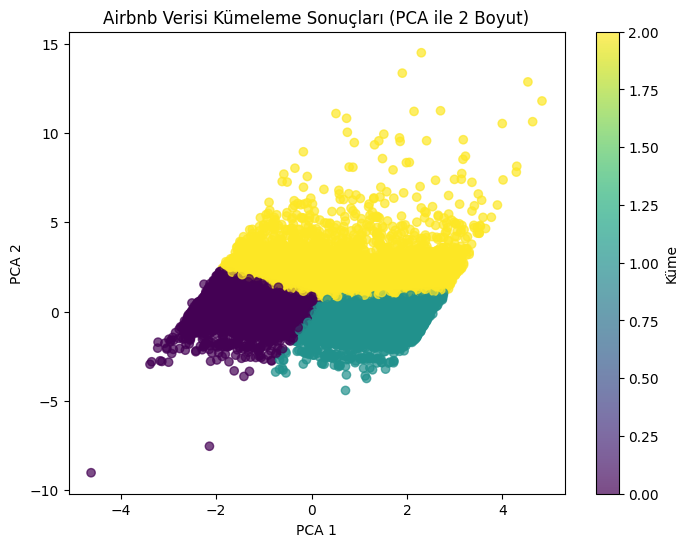

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_kmeans if score_kmeans >= score_hier else y_pred_hier, cmap='viridis', alpha=0.7)
plt.title('Airbnb Verisi Kümeleme Sonuçları (PCA ile 2 Boyut)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Küme')
plt.show()

Bu çalışmada, Airbnb Open Data veri seti üzerinde K-Means ve Hiyerarşik Kümeleme algoritmalarını karşılaştırdık. En iyi performansı gösteren modelin hiperparametrelerini optimize ederek nihai modelin başarımını değerlendirdik.